# COVID-19 Differential Expression Analysis

## Overview
This notebook performs cell-type-specific differential expression (DE) analysis between COVID and Control lung samples using annotated scRNA-seq data. Focus is placed on:
- **Alveolar macrophages** (inflammatory mediators)
- **NK cells** (innate antiviral responders)

## Key Steps

### Data Loading
- Loaded: `clustered_final_celltypes.h5ad`
- Inspected `adata.obs` for condition and annotation fields
- Set seed for reproducibility

### Differential Expression (COVID vs Control)
- Focused on: Alveolar macrophages and NK cells
- Method: Wilcoxon rank-sum test (`sc.tl.rank_genes_groups`)
- Exported: 
  - `DEG_Alveolar_macrophages_COVID_vs_Control.csv`
  - `DEG_NK_cells_COVID_vs_Control.csv`

### Filtering of Significant COVID-Upregulated Genes
- Criteria:
  - Adjusted p-value (`pvals_adj`) < 0.05
  - Positive log-fold change (`logfoldchanges > 0`)
- Purpose: Focus on genes most upregulated in COVID
- Output:
  - `Significant_DEG_Alveolar_macrophages_COVID.csv`
  - `Significant_DEG_NK_cells_COVID.csv`

### Visualization (COVID Samples Only)
- Subset: Only COVID samples for Alveolar macrophages and NK cells
- Selected top 5 DEGs per cell type
- Plots:
  - Dot plot (`dotplot__COVID_DEG_dotplot.png`)
  - Heatmap with dendrogram (`heatmap_COVID_DEG_heatmap.png`)

## Interpretation Summary

| Cell Type             | Top DEGs                          | Function                                      |
|-----------------------|-----------------------------------|-----------------------------------------------|
| Alveolar macrophages  | NEAT1, CTSD, PSAP, HSP90AA1, B2M | Antiviral signaling, lysosomal activity       |
| NK cells              | HSPA1A, PTMA, PDE4D, TPST1, FTL  | IFN signaling, stress and immune response     |

- Dot plot revealed **cell-type-specific expression patterns**.
- Heatmap confirmed distinct **expression signatures per cell type**.
- DEGs represent candidate **biomarkers or therapeutic targets** in COVID lungs.

## Output Files
- `DEG_*.csv`: Complete DE results per cell type
- `Significant_DEG_*.csv`: Filtered DEGs (COVID-upregulated)
- `dotplot__COVID_DEG_dotplot.png`: Expression dot plot of top DEGs
- `heatmap_COVID_DEG_heatmap.png`: Heatmap of top DEGs across cell types


In [2]:
#REQUIRED PACKAGES
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#Set seed for reproducibility
random.seed(42)
np.random.seed(42)

In [3]:
#STEP 1: LOAD ANNOTATED DATA
adata = sc.read("clustered_final_celltypes.h5ad")

In [4]:
print(adata.obs.columns)

Index(['sample', 'condition', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'n_genes', 'doublet_score', 'predicted_doublet',
       'leiden', 'log1p_total_counts', 'log1p_n_genes_by_counts',
       'celltypist_labels', 'dominant_cell_type', 'final_celltype',
       'leiden_int', 'final_label_cluster', 'cluster_celltype_label',
       'annotated_cluster'],
      dtype='object')


Running DE for: Alveolar macrophages
Saved: DEG_Alveolar_macrophages_COVID_vs_Control.csv


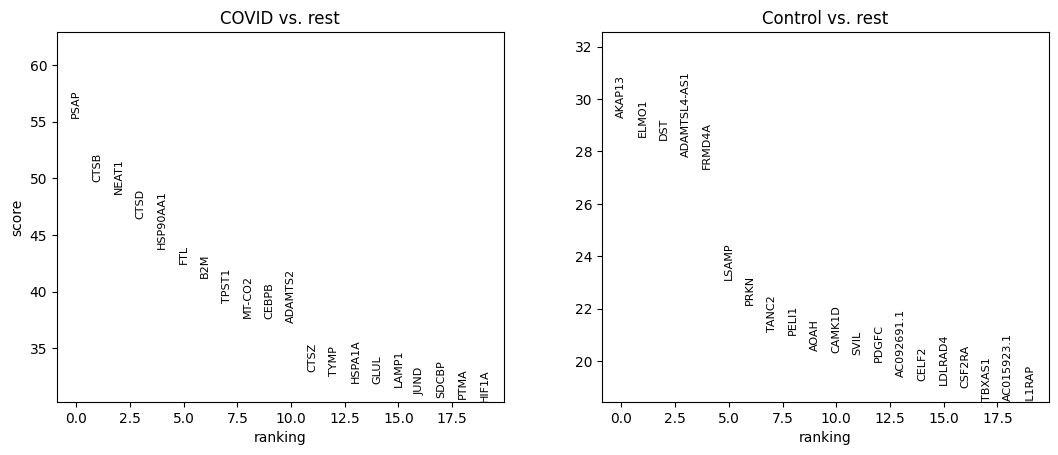

Running DE for: NK cells
Saved: DEG_NK_cells_COVID_vs_Control.csv


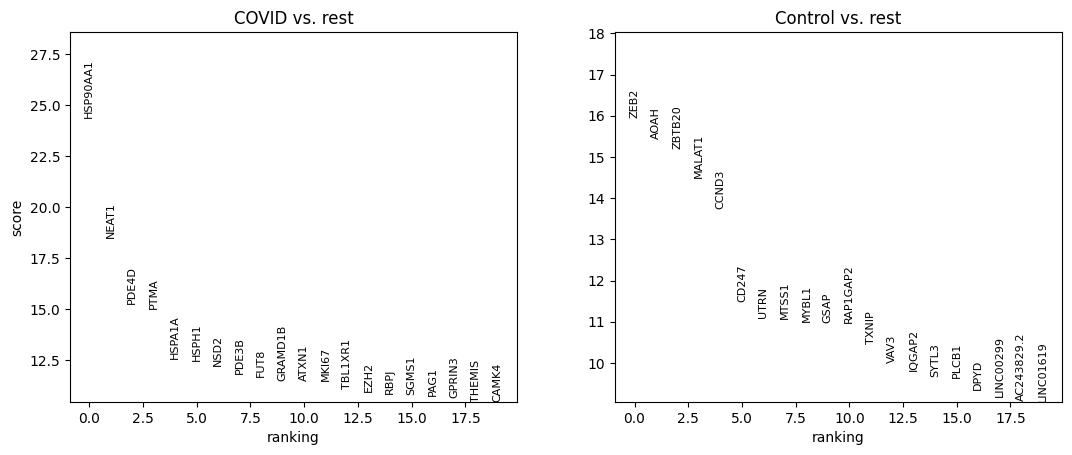

In [12]:
#STEP 2: CHOOSE CELL TYPES TO ANALYZE
celltypes_of_interest = ['Alveolar macrophages', 'NK cells']

for celltype in celltypes_of_interest:
    print(f"Running DE for: {celltype}")
    
    # Subset data for this cell type
    adata_subset = adata[adata.obs['final_celltype'] == celltype].copy()
    
    # Ensure 'condition' column is categorical
    adata_subset.obs['condition'] = adata_subset.obs['condition'].astype('category')
    
    # Perform differential expression
    sc.tl.rank_genes_groups(
        adata_subset,
        groupby='condition',
        method='wilcoxon',
        use_raw=True,
        pts=True
    )

    # Export top genes for COVID vs Control in this cell type
    df = sc.get.rank_genes_groups_df(adata_subset, group='COVID')
    filename = f"DEG_{celltype.replace(' ', '_')}_COVID_vs_Control.csv"
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

    #Plot top 20 genes
    sc.pl.rank_genes_groups(adata_subset, n_genes=20, sharey=False, show=True)

In [16]:
#STEP 3: Reload and Preview DEG Results
deg_alveolar = pd.read_csv("DEG_Alveolar_macrophages_COVID_vs_Control.csv")
deg_nk = pd.read_csv("DEG_NK_cells_COVID_vs_Control.csv")

In [17]:
#View the head
deg_alveolar.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,PSAP,55.377560,3.194773,0.000000e+00,0.000000e+00,0.760084,0.287631
1,CTSB,49.712940,2.407233,0.000000e+00,0.000000e+00,0.801370,0.460300
2,NEAT1,48.659050,1.364168,0.000000e+00,0.000000e+00,0.968512,0.923507
3,CTSD,46.447247,3.425889,0.000000e+00,0.000000e+00,0.617199,0.193916
4,HSP90AA1,43.739290,4.360773,0.000000e+00,0.000000e+00,0.513508,0.079624
5,FTL,42.435867,3.184226,0.000000e+00,0.000000e+00,0.590278,0.198837
6,B2M,41.206127,3.287384,0.000000e+00,0.000000e+00,0.534151,0.120555
7,TPST1,39.047104,4.975206,0.000000e+00,0.000000e+00,0.426941,0.030866
8,MT-CO2,37.654613,2.075733,2.749771e-310,9.701497e-307,0.763604,0.420935
9,CEBPB,37.561460,3.186981,9.158660e-309,2.908149e-305,0.473744,0.096175


In [25]:
deg_alveolar.tail(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
31743,AOAH,-20.378510,-1.439877,2.594334e-92,9.806890e-90,0.290430,0.452024
31744,PELI1,-20.999819,-1.666317,6.583694e-98,2.714961e-95,0.236587,0.411317
31745,TANC2,-21.102884,-1.392186,7.482957e-99,3.126399e-96,0.311263,0.463207
31746,PRKN,-22.148490,-2.835806,1.078704e-108,5.524531e-106,0.066495,0.287855
31747,LSAMP,-23.097992,-4.012225,4.850132e-118,2.961658e-115,0.034627,0.269067
31748,FRMD4A,-27.352312,-1.571787,1.013637e-164,9.196007e-162,0.362158,0.562514
31749,ADAMTSL4-AS1,-27.810545,-3.328217,3.234177e-170,3.111964e-167,0.068398,0.343100
31750,DST,-28.449028,-2.070419,5.009998e-178,5.681517e-175,0.210807,0.464326
31751,ELMO1,-28.560880,-1.160482,2.057934e-179,2.420207e-176,0.593227,0.722657
31752,AKAP13,-29.300371,-0.918233,1.025925e-188,1.303048e-185,0.749049,0.823529


In [18]:
deg_nk.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,HSP90AA1,24.388230,7.154504,2.280141e-131,7.240131e-127,0.578012,0.016949
1,NEAT1,18.475471,2.195805,3.253757e-76,5.165827e-72,0.754201,0.415819
2,PDE4D,15.285698,4.938057,9.523777e-53,6.048170e-49,0.374940,0.021469
3,PTMA,15.036547,4.056044,4.230511e-51,1.919020e-47,0.386462,0.038418
4,HSPA1A,12.556111,30.225187,3.679787e-36,1.168443e-32,0.290927,0.000000
5,HSPH1,12.477611,5.808752,9.891044e-36,2.855185e-32,0.298128,0.009040
6,NSD2,12.219774,2.519251,2.437619e-34,6.450144e-31,0.383101,0.097175
7,PDE3B,11.815284,1.787163,3.254473e-32,7.949174e-29,0.523764,0.237288
8,FUT8,11.697006,2.058732,1.320294e-31,2.994521e-28,0.427268,0.155932
9,GRAMD1B,11.508048,3.438069,1.201678e-30,2.543793e-27,0.308209,0.041808


#### Filtering Significant Upregulated Genes in COVID
Helps us to identify the most statistically significant genes that are *upregulated* in COVID-19 for the two cell types.

**Logic**:
- `pvals_adj < 0.05`: Filters for statistically significant genes (FDR-corrected).
- `logfoldchanges > 0`: Retains only genes upregulated in COVID vs Control (+ve).
- `sort_values('pvals_adj')`: Ranks genes by significance.

This helps pinpoint key COVID-responsive genes per cell type — such as cytokines or interferon-stimulated genes, which may drive disease pathology or immune activation.

In [20]:
#STEP 4: Filter for Significant Upregulated Genes in COVID
# For Alveolar
sig_alveolar = deg_alveolar[
    (deg_alveolar['pvals_adj'] < 0.05) &
    (deg_alveolar['logfoldchanges'] > 0)
].sort_values('pvals_adj')

In [21]:
# For NK cells
sig_nk = deg_nk[
    (deg_nk['pvals_adj'] < 0.05) &
    (deg_nk['logfoldchanges'] > 0)
].sort_values('pvals_adj')

In [22]:
#View the head
sig_alveolar.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,PSAP,55.377560,3.194773,0.000000e+00,0.000000e+00,0.760084,0.287631
7,TPST1,39.047104,4.975206,0.000000e+00,0.000000e+00,0.426941,0.030866
6,B2M,41.206127,3.287384,0.000000e+00,0.000000e+00,0.534151,0.120555
5,FTL,42.435867,3.184226,0.000000e+00,0.000000e+00,0.590278,0.198837
3,CTSD,46.447247,3.425889,0.000000e+00,0.000000e+00,0.617199,0.193916
4,HSP90AA1,43.739290,4.360773,0.000000e+00,0.000000e+00,0.513508,0.079624
1,CTSB,49.712940,2.407233,0.000000e+00,0.000000e+00,0.801370,0.460300
2,NEAT1,48.659050,1.364168,0.000000e+00,0.000000e+00,0.968512,0.923507
8,MT-CO2,37.654613,2.075733,2.749771e-310,9.701497e-307,0.763604,0.420935
9,CEBPB,37.561460,3.186981,9.158660e-309,2.908149e-305,0.473744,0.096175


In [23]:
#View the head
sig_nk.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,HSP90AA1,24.388230,7.154504,2.280141e-131,7.240131e-127,0.578012,0.016949
1,NEAT1,18.475471,2.195805,3.253757e-76,5.165827e-72,0.754201,0.415819
2,PDE4D,15.285698,4.938057,9.523777e-53,6.048170e-49,0.374940,0.021469
3,PTMA,15.036547,4.056044,4.230511e-51,1.919020e-47,0.386462,0.038418
4,HSPA1A,12.556111,30.225187,3.679787e-36,1.168443e-32,0.290927,0.000000
5,HSPH1,12.477611,5.808752,9.891044e-36,2.855185e-32,0.298128,0.009040
6,NSD2,12.219774,2.519251,2.437619e-34,6.450144e-31,0.383101,0.097175
7,PDE3B,11.815284,1.787163,3.254473e-32,7.949174e-29,0.523764,0.237288
8,FUT8,11.697006,2.058732,1.320294e-31,2.994521e-28,0.427268,0.155932
9,GRAMD1B,11.508048,3.438069,1.201678e-30,2.543793e-27,0.308209,0.041808


In [24]:
#STEP 5: Save Filtered Significant DEGs (Optional)
sig_alveolar.to_csv("Significant_DEG_Alveolar_macrophages_COVID.csv", index=False)
sig_nk.to_csv("Significant_DEG_NK_cells_COVID.csv", index=False)

In [ ]:
#STEP 6: Visualisation. Dot and Heatmap

In [34]:
#Step 6.1: Subset to COVID samples
adata_covid = adata[adata.obs['condition'] == 'COVID'].copy()

In [35]:
#Step 6.2: Subset to Alveolar macrophages & NK cells
adata_covid_subset = adata_covid[
    adata_covid.obs['final_celltype'].isin(['Alveolar macrophages', 'NK cells'])
].copy()
#Limit analysis to relevant cell types where DEGs were previously identified.

In [36]:
#Step 6.3: Select top DEGs per cell type
top_genes = sig_alveolar['names'].head(5).tolist() + sig_nk['names'].head(5).tolist()
#Merge top 5 DEGs from each cell type for comparative visualization.

In [39]:
#Modify obs object
adata_covid_subset.obs.rename(columns={'final_celltype': 'Cell Type'}, inplace=True)

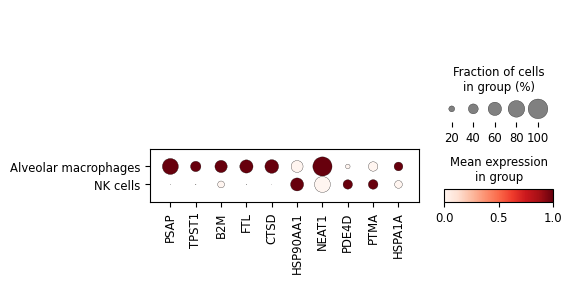

In [42]:
#Step 6.4 Dot Plot
sc.pl.dotplot(
    adata_covid_subset,
    var_names=top_genes,
    groupby='Cell Type',
    standard_scale='var',
    cmap='Reds',
    show=True,
    save='_COVID_DEG_dotplot.png'  # Will save to `figures/` by default
)

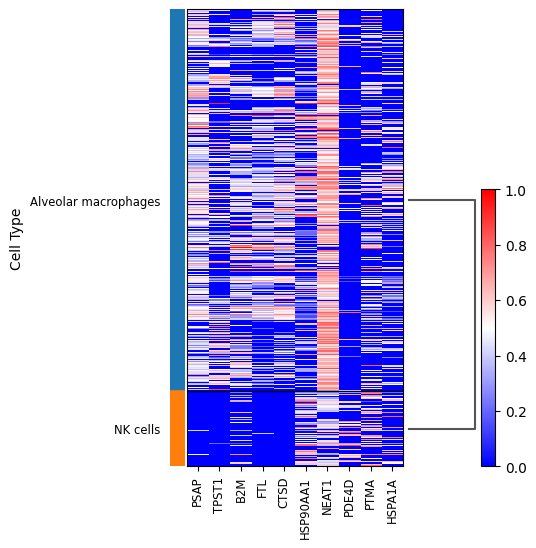

In [43]:
#Step 6.5: Improved Heatmap
sc.pl.heatmap(
    adata_covid_subset,
    var_names=top_genes,
    groupby='Cell Type',
    standard_scale='var',
    cmap='bwr',
    dendrogram=True,
    show=True,
    save='_COVID_DEG_heatmap.png'
)

## Interpretation of Differential Expression in COVID-19 Lungs

### Why Alveolar Macrophages & NK Cells?
- These cell types showed the **strongest abundance shifts** between COVID and Control (earlier boxplot).
- Biologically relevant:  
  - **Alveolar macrophages** drive inflammation and antigen presentation.  
  - **NK cells** are key to innate antiviral immunity.

---

### Top Upregulated Genes (COVID vs Control)

| Cell Type             | Upregulated Genes                           | Function |
|-----------------------|---------------------------------------------|----------|
| **Alveolar Macrophages** | NEAT1, CTSD, PSAP, HSP90AA1, B2M             | Antiviral response, lysosomal activity, MHC signaling |
| **NK Cells**             | HSPA1A, PTMA, PDE4D, TPST1, FTL             | Stress response, IFN signaling, immune activation |

- Genes selected based on **adjusted p-value < 0.05** and **logFC > 0**.

---

### Dot Plot Summary
- Dot size: % of cells expressing the gene.
- Dot color: Mean expression.
- Confirms **cell-type-specific activation**:
  - Alveolar macrophages → NEAT1, CTSD, PSAP  
  - NK cells → HSPA1A, PDE4D, PTMA

---

### Heatmap Summary
- Z-scored expression of top DEGs across COVID samples.
- Clusters show clear **separation of gene programs** in NK vs Alveolar cells.
- Supports our **annotation validity** and biological insight.

---

### Summary
These DEGs reflect **COVID-driven immune activation** in alveolar macrophages and NK cells, highlighting potential **targets for therapeutic intervention** and deeper pathway exploration.
